Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Read pre-processed data

In [ ]:
adata = sc.read('data/core_GBmap.h5ad')
adata

AnnData object with n_obs × n_vars = 431535 × 36498
    obs: 'author', 'patient', 'celltype_malignant', 'celltype_major', 'celltype_minor', 'gender', 'location', 'EGFR', 'platform', 'method', 'age', 'MET', 'p53', 'TERT', 'ATRX', 'PTEN', 'MGMT', 'sample', 'celltype_original', 'KI_67', 'region', 'Tissue', 'chr1p19q', 'stage', 'Verhaak_classification', 'PDGFR', 'gs_prediction', 'gs_prediction_main', 'gs_prediction_detailed', 'cnv_full_geneset', 'cnv_filtered_geneset', 'celltype_assigned'
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="author",
    layer="counts",
    subset=True)

In [ ]:
### train the model including only samples that have used cells (not nuclei)
source_adata = adata[adata.obs['method'].isin(['cell'])].copy()

### Set relevant anndata.obs labels and training length

In [ ]:
condition_key = 'author'
cell_type_key = 'celltype_assigned'

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

### Create SCANVI model and train it on fully labelled reference dataset

In [ ]:
sca.dataset.setup_anndata(source_adata, layer = 'counts', batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["author"]                                              
INFO     Using labels from adata.obs["celltype_assigned"]                                    
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 338564 cells, 5000 vars, 17       
         batches, 14 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [ ]:
vae = sca.models.SCANVI(
    source_adata,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda = True # indicate to use gpu!
)

In [ ]:
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

Labelled Indices:  338564
Unlabelled Indices:  0


In [ ]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 200 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  61%|██████    | 305/500 [2:27:34<1:33:19, 28.72s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  61%|██████    | 305/500 [2:28:02<1:34:39, 29.12s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training tim

In [ ]:
ref_path = 'scarches_models/ref_model_scanvi/'
vae.save(ref_path, overwrite=True)

reference_latent = sc.AnnData(vae.get_latent_representation())

In [ ]:
source_adata.write_h5ad('scarches_models/ref_model_scanvi/scarches_SCANVI_cells_5000hvg.h5ad')

### Create anndata file of latent representation and compute UMAP

In [ ]:
reference_latent.obs["celltype_assigned"] = source_adata.obs["celltype_assigned"].tolist()
reference_latent.obs["celltype_original"] = source_adata.obs["celltype_original"].tolist()
reference_latent.obs["author"] = source_adata.obs["author"].tolist()
reference_latent.obs["platform"] = source_adata.obs["platform"].tolist()
reference_latent.obs["method"] = source_adata.obs["method"].tolist()
reference_latent.obs["gs_prediction_main"] = source_adata.obs["gs_prediction_main"].tolist()
reference_latent.obs["gs_prediction_detailed"] = source_adata.obs["gs_prediction_detailed"].tolist()
reference_latent.obs["patient"] = source_adata.obs["patient"].tolist()
reference_latent.obs["gender"] = source_adata.obs["gender"].tolist()
reference_latent.obs["cnv_filtered_geneset"] = source_adata.obs["cnv_filtered_geneset"].tolist()
reference_latent.obs["cnv_full_geneset"] = source_adata.obs["cnv_full_geneset"].tolist()
reference_latent.obs["author"] = source_adata.obs["author"].tolist()

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent, resolution = 0.5)
sc.tl.umap(reference_latent)

... storing 'celltype_assigned' as categorical
... storing 'celltype_original' as categorical
... storing 'author' as categorical
... storing 'platform' as categorical
... storing 'method' as categorical
... storing 'gs_prediction_main' as categorical
... storing 'gs_prediction_detailed' as categorical
... storing 'patient' as categorical
... storing 'gender' as categorical
... storing 'cnv_filtered_geneset' as categorical
... storing 'cnv_full_geneset' as categorical


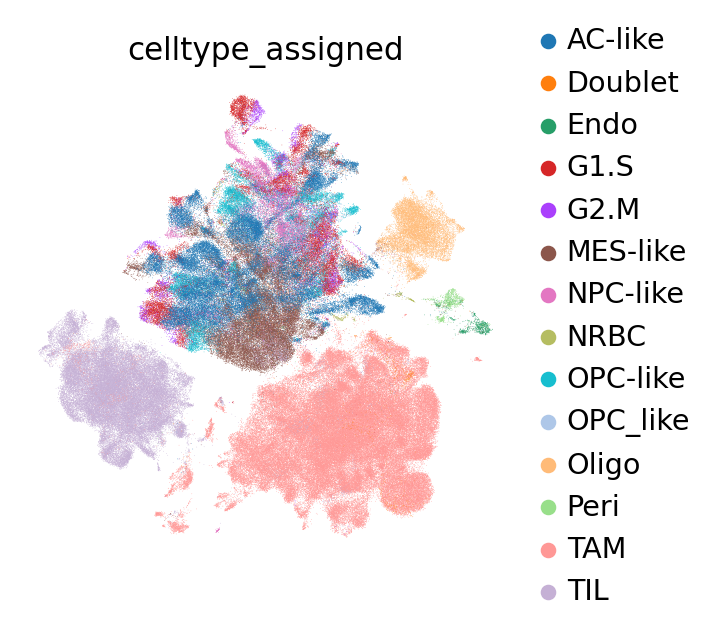

In [ ]:
sc.pl.umap(reference_latent,
           color=['celltype_assigned'],
           frameon=False,
           wspace=0.6,
           )

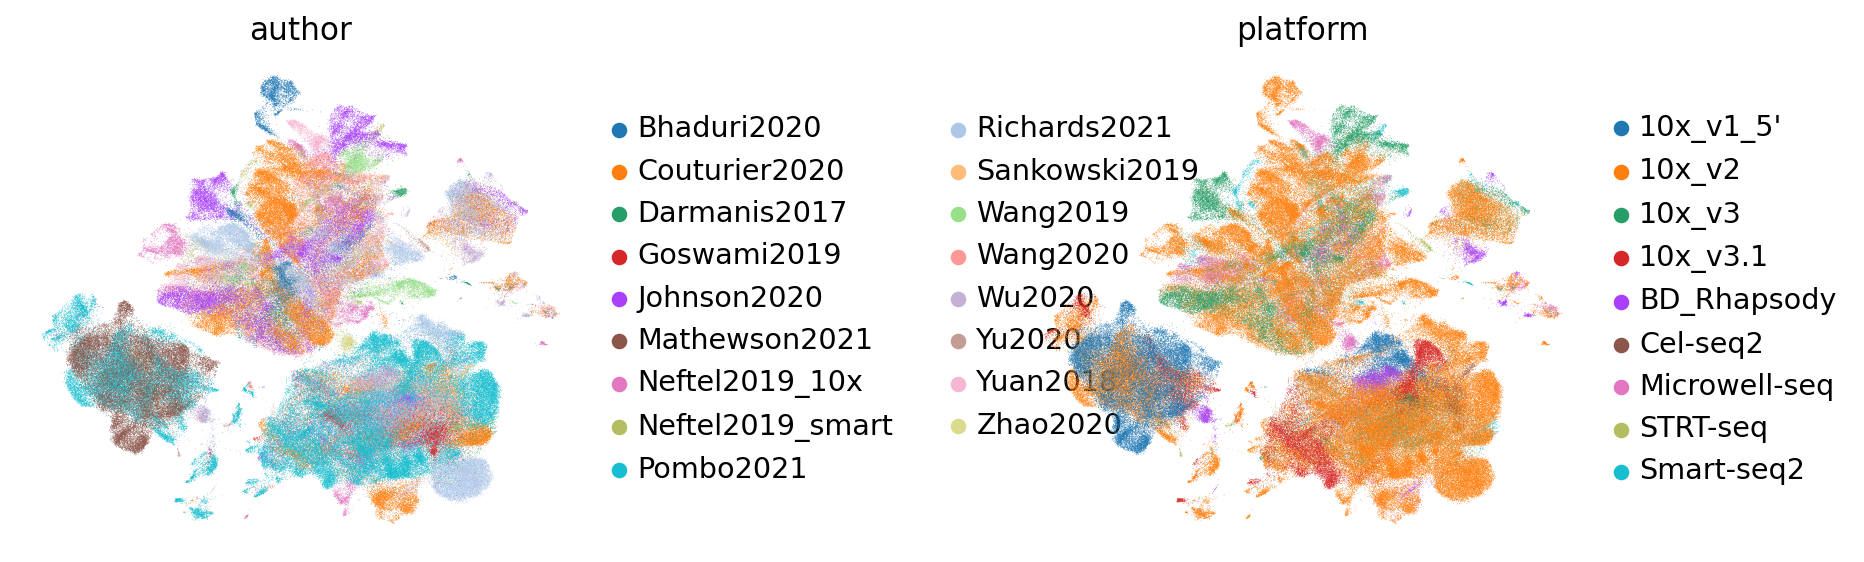

In [ ]:
sc.pl.umap(reference_latent,
           color=['author', 'platform'],
           frameon=False,
           wspace=0.6,
           )

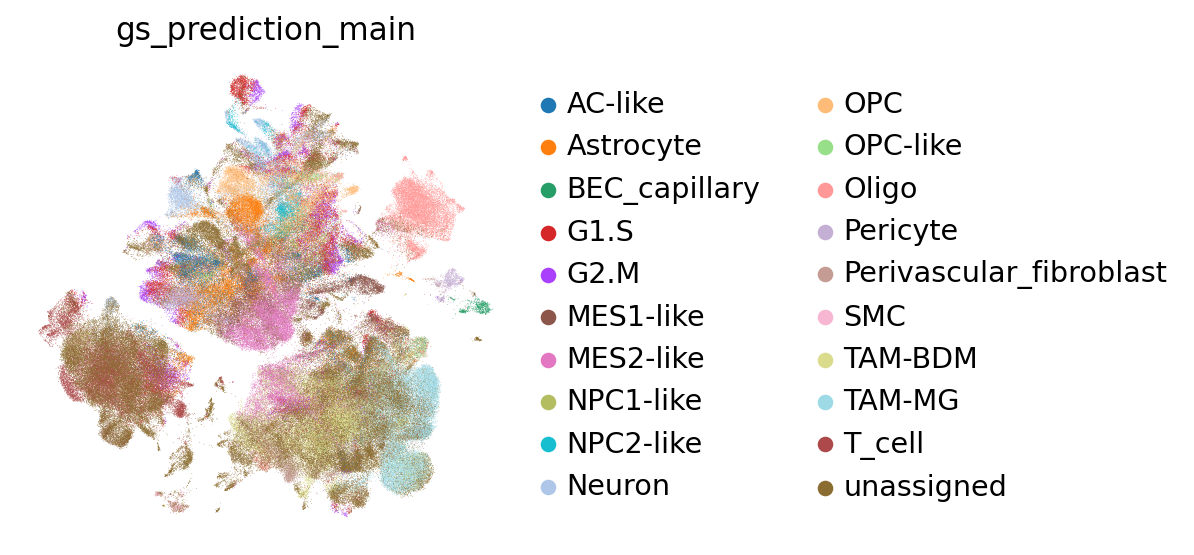

In [ ]:
sc.pl.umap(reference_latent,
           color=['gs_prediction'],
           frameon=False,
           wspace=0.6,
           )

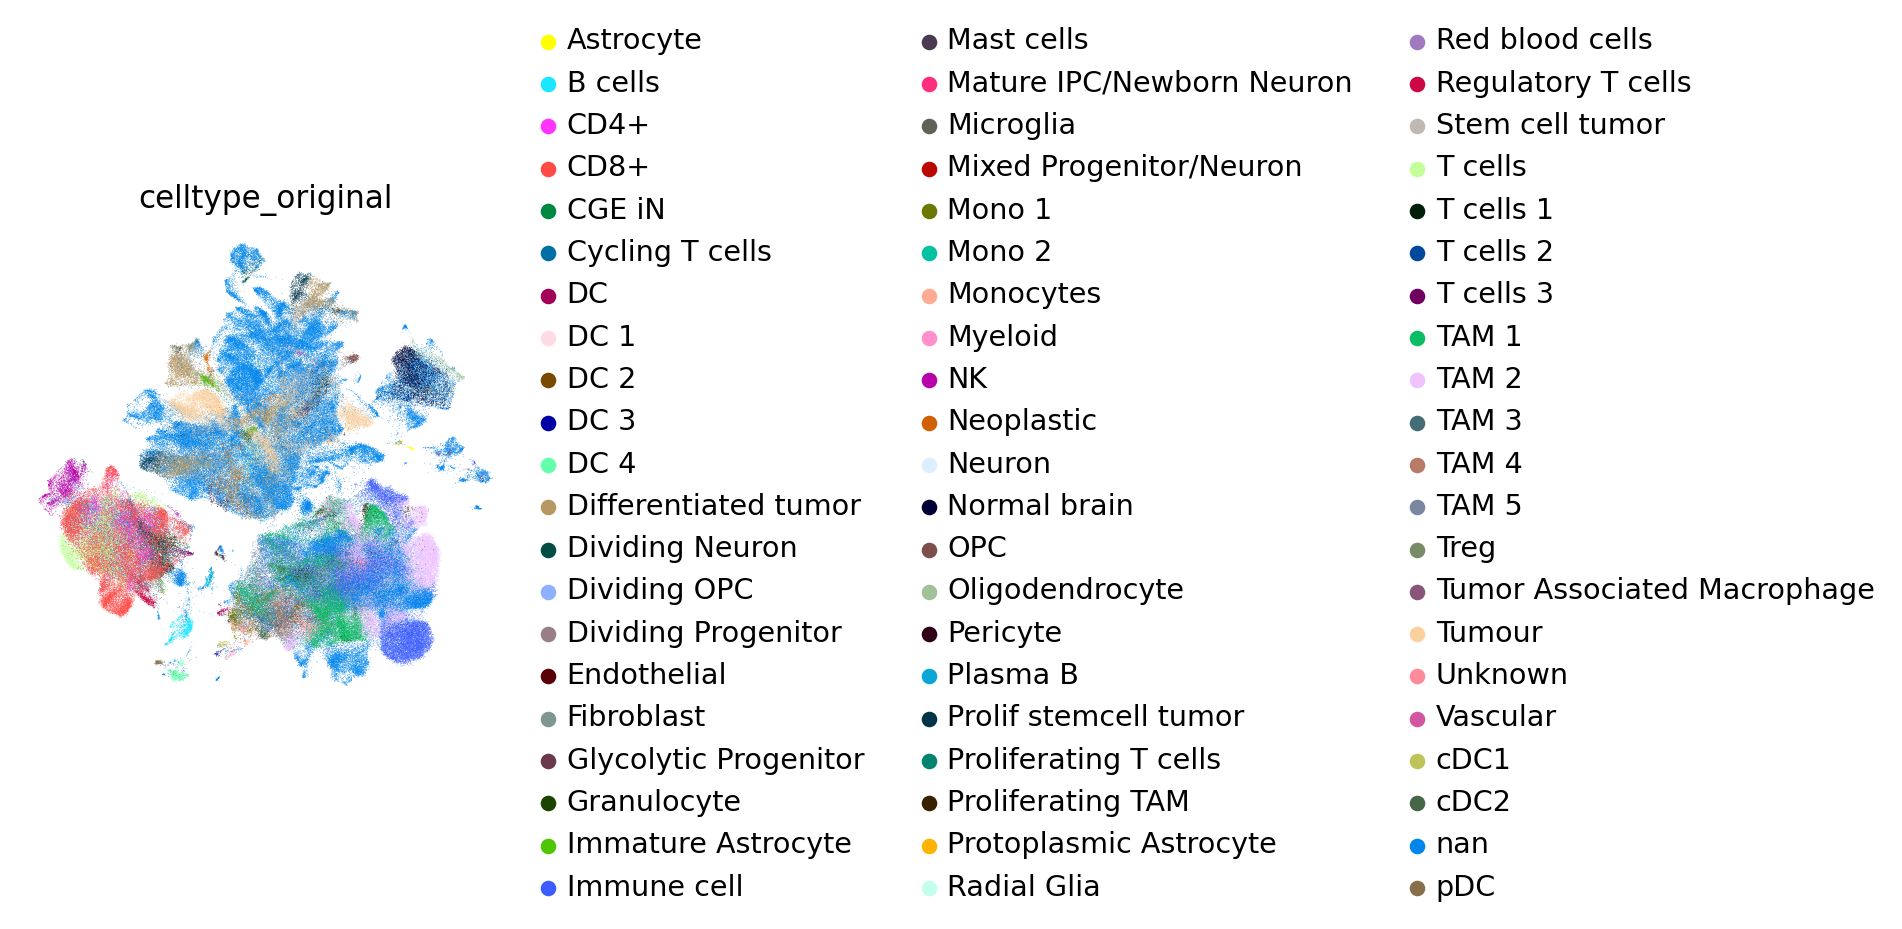

In [ ]:
sc.pl.umap(reference_latent,
           color=['celltype_original'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.celltype_assigned)))

Acc: 0.916426436360629


### Exploring several cluster resolutions

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1, key_added="leiden_1")

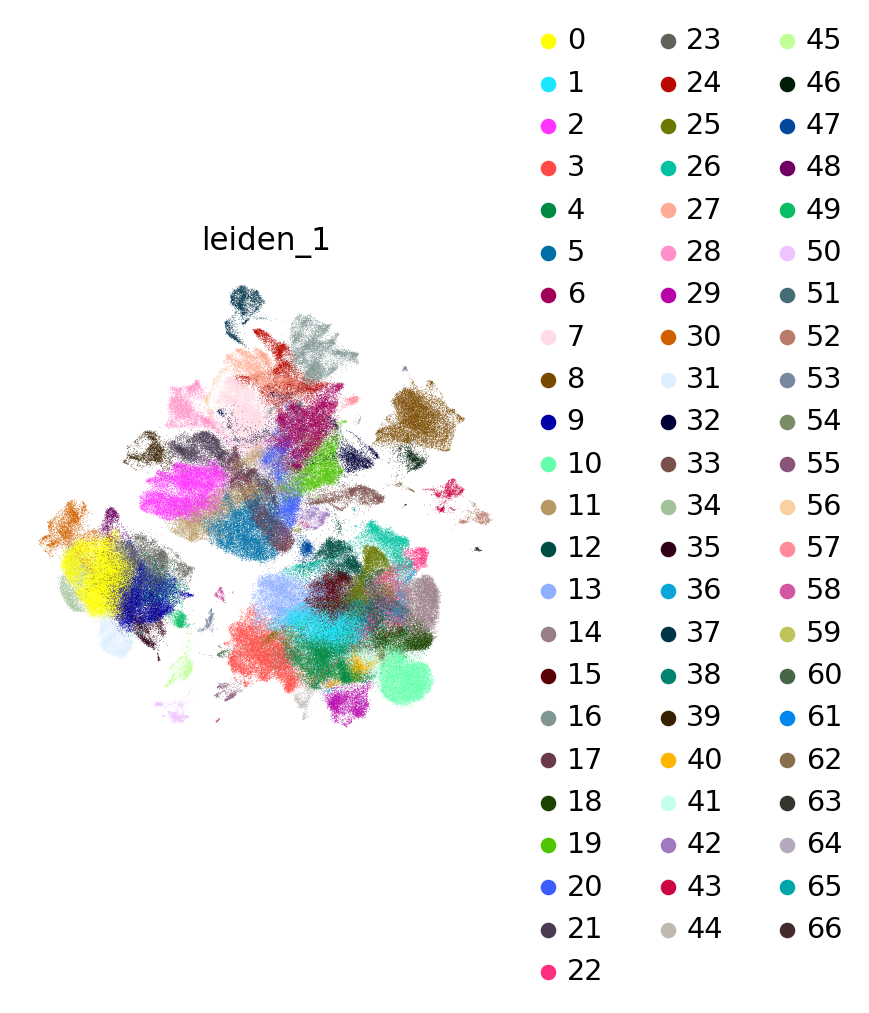

In [ ]:
sc.pl.umap(reference_latent,
           color=['leiden_1'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.2, key_added="leiden_1.2")

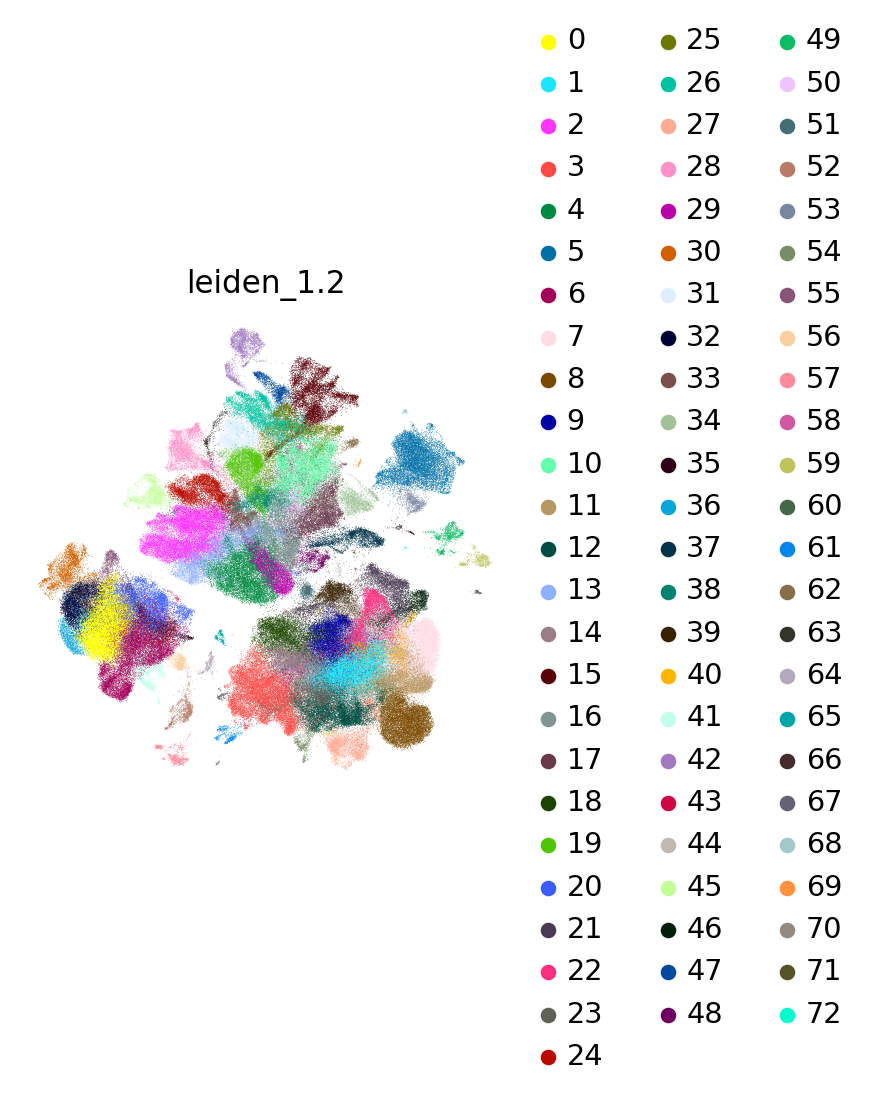

In [ ]:
sc.pl.umap(reference_latent,
           color=['leiden_1.2'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.5, key_added="leiden_1.5")

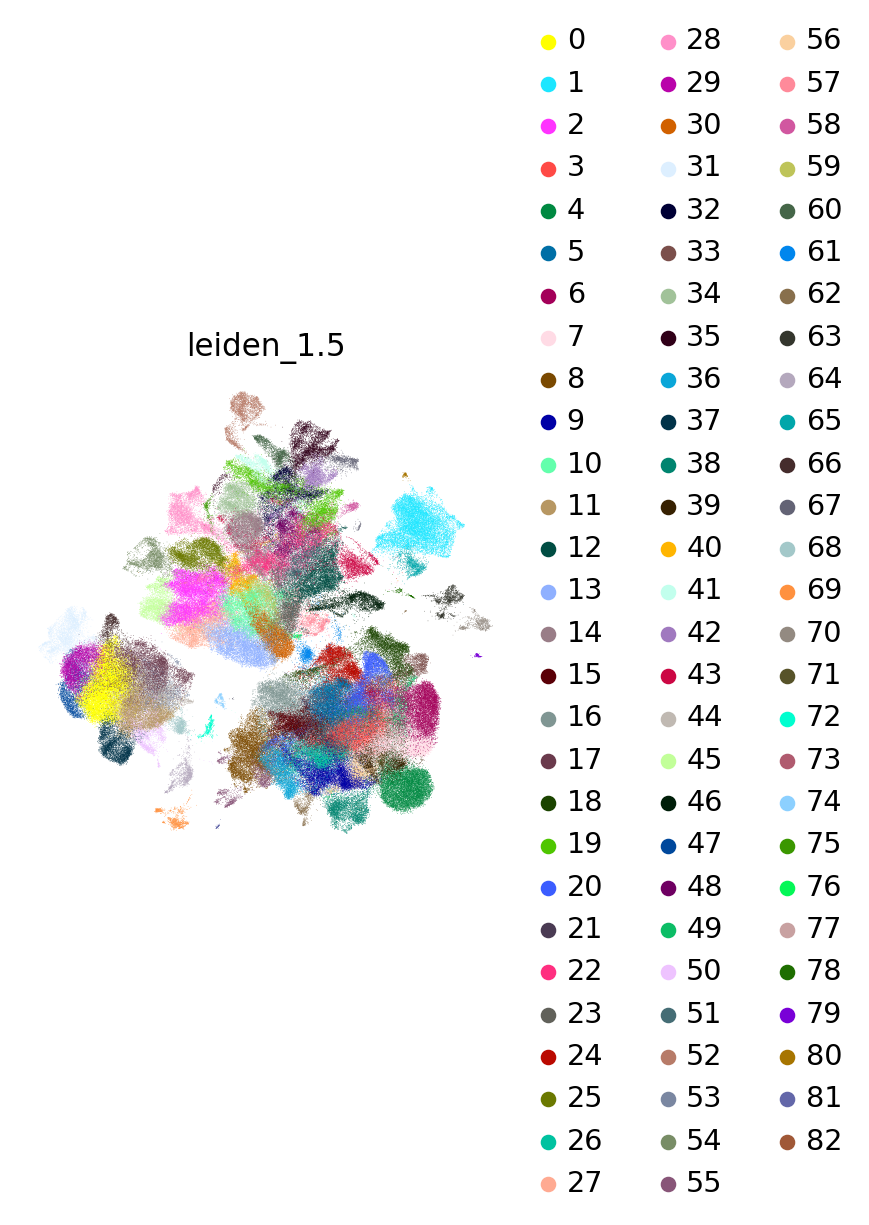

In [ ]:
sc.pl.umap(reference_latent,
           color=['leiden_1.5'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.write_h5ad('scarches_models/ref_model_scanvi/scarches_SCANVI_cells_5000hvg_latent.h5ad')